In [64]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm

torch.__version__

'1.4.0a0+fe76af9'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
#path = "drive/My Drive/AML/"
path = ""

df = pd.read_csv(path + "pmsm_temperature_data.csv")

In [4]:
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


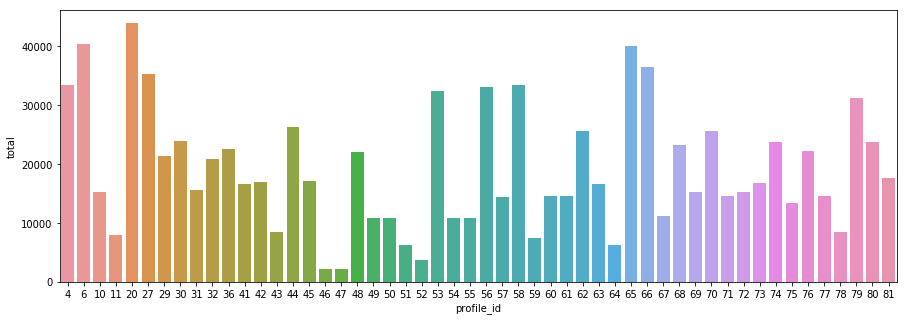

In [5]:
plt.figure(figsize=(15,5))
count = pd.DataFrame(df[['profile_id']].groupby('profile_id').size()).reset_index()
count.columns = ["profile_id", "total"]
sns.barplot(count.profile_id,count.total)
plt.show()

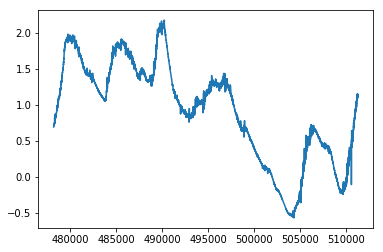

In [6]:
plt.plot(df[df.profile_id==56].pm)
plt.show()

In [7]:
df_sep = [df[df.profile_id==profile].drop(['profile_id','torque'], axis=1).reset_index(drop=True) for profile in df.profile_id.unique()]

In [8]:
df_sep[16]

,ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
0,-0.595910,2.171364,-1.589776,-0.587723,1.103304,-1.878195,0.680967,1.017145,1.882656,1.437981,1.053870
1,-0.621160,2.170850,-1.571330,-0.500914,1.099682,-1.804746,0.671327,1.021259,1.882521,1.439262,1.065586
2,-0.631429,2.170527,-1.557825,-0.424030,1.096316,-1.742421,0.663120,1.022086,1.882713,1.442306,1.080192
3,-0.626384,2.170454,-1.562527,-0.442516,1.098146,-1.757560,0.664252,1.024800,1.882829,1.446316,1.095144
4,-0.618749,2.170683,-1.576954,-0.534982,1.111325,-1.832702,0.667031,1.029729,1.883059,1.449144,1.108085
...,...,...,...,...,...,...,...,...,...,...,...
2174,-0.463984,2.172318,0.507567,0.353152,-0.347175,1.005747,-0.489718,1.804289,2.280776,1.991620,1.560164
2175,-0.460619,2.172481,0.507999,0.353206,-0.347188,1.005798,-0.490083,1.803187,2.280447,1.991620,1.556740
2176,-0.456195,2.172659,0.508290,0.353097,-0.347194,1.005808,-0.490337,1.801625,2.279769,1.991620,1.554234
2177,-0.453024,2.172829,0.508741,0.353127,-0.347196,1.005798,-0.490511,1.799392,2.279384,1.991620,1.551217


In [9]:
class GRU_Net(nn.Module):
    def __init__(self, features, hidden, h1, h2, out):
        super(GRU_Net, self).__init__()
        self.hidden_size = hidden
        self.features = features
        self.gru = nn.GRU(self.features, self.hidden_size, 1, #feature_size, hidden_size, num_layer
                            batch_first = True) 
        self.fc1 = nn.Linear(self.hidden_size, 
                                h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out)
        #self.hidden = None #torch.randn(1, ??, self.hidden) #num_layer, batch, hidden_size

    def forward(self, x):
        batch_size, _, _ = x.shape 

        #if self.hidden is not None:
        #    x, self.hidden =  self.gru(x, self.hidden)
        #else:
        #    x, self.hidden =  self.gru(x)
        
        x, _ =  self.gru(x)
        x = x[:,-1].view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

In [10]:
def sliding_window(dataset, target_var, inp, out):
    for j, X in enumerate(dataset):
        if j==51: #it's validation time
            pass

        target = X[[target_var]]
        num_features = len(X.columns)

        for i in range(X.shape[0]):
            if i > inp + out - 1:
                features = X.iloc[i-inp-out:i-out,].values.reshape(inp,num_features)
                pred = target.iloc[i]

                yield np.array(features), np.array(pred)

In [11]:
np.sum([x.shape[0] for x in df_sep])

998070

In [12]:
gru = GRU_Net(features=11, hidden=64, h1=64, h2=32, out=1).to(device)

criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(gru.parameters(),lr=0.001)

gru.train()
batch_size = 510

df_length = np.sum([x.shape[0] for x in df_sep]) - df_sep[51].shape[0]

for t in range(2):
    gen = sliding_window(df_sep, "pm", 300, 1)
    for b in tqdm(range(0, df_length, batch_size)):
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except:
                break

        inpt = np.array(X_train).reshape(-1, 300, 11)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = gru(x_batch) 
            loss = criterion(output.view(-1), y_batch.view(-1))  

            loss.backward(retain_graph=True)
            optimizer.step()        
            optimizer.zero_grad()
        except:
            print("something happened")
            print(inpt.shape)
            print(x_batch.size())
            break
        
    print('step : ' , t+1 , 'loss : ' , loss.item())
    print()

/home/pranav/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:134: UserWarning: 
    Found GPU0 GeForce GT 750M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))



step :  1 loss :  0.0035691577941179276




step :  2 loss :  0.00036484983866102993



In [25]:
gru.to(device)

GRU_Net(
  (gru): GRU(11, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [55]:
test_gen = sliding_window([df_sep[51]], "pm", 300, 1)
batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, df_sep[51].shape[0], batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, 300, 11)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = gru(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

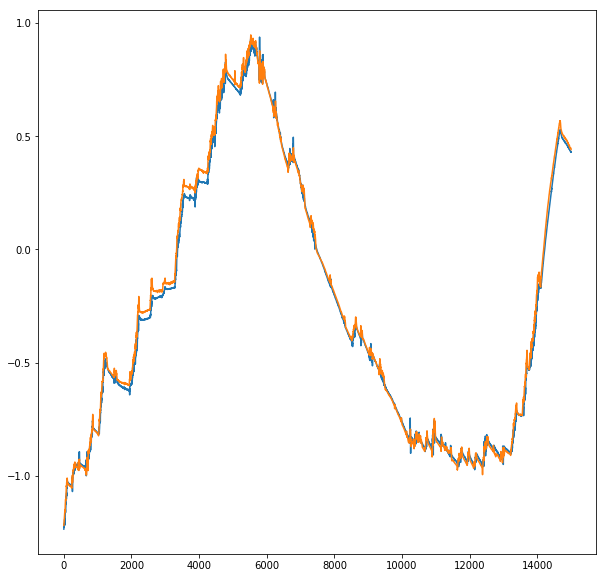

In [59]:
y_test = np.array(y_test).reshape(-1)
plt.figure(figsize=(10,10))
plt.plot(y_test)
plt.plot(y_pred_all)

plt.show()

In [63]:
np.mean(np.abs(y_test - y_pred_all)/y_test)

-0.0488383989205866